# 8) 메시지 삭제

그래프의 일반적인 상태 중 하나는 메시지 목록입니다. 일반적으로 해당 상태에 메시지를 추가만 합니다. 하지만 때로는 **메시지를 제거** 해야 할 수도 있습니다. 

이를 위해 `RemoveMessage` 수정자를 사용할 수 있습니다. 그리고, `RemoveMessage` 수정자는 `reducer` 키를 가진다는 것입니다. 

기본 `MessagesState`는 messages 키를 가지고 있으며, 해당 키의 reducer는 이러한 `RemoveMessage` 수정자를 허용합니다.

이 reducer는 `RemoveMessage`를 사용하여 키에서 메시지를 삭제합니다.

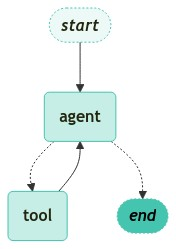

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
from typing import Literal

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph

# API 키 정보 로드
load_dotenv()

# 기본적인 graph 구조---------------
memory = MemorySaver()

# 웹 검색 기능을 모방하는 도구 함수 정의
@tool
def search(query: str):
    """Call to surf on the web."""
    return "웹 검색 결과: LangGraph 한글 튜토리얼은 https://wikidocs.net/233785 에서 확인할 수 있습니다."

tools = [search]
tool_node = ToolNode(tools)

model = ChatOpenAI(model_name = "gpt-4o-mini")
bound_model = model.bind_tools(tools)

# 대화 상태에 따른 다음 실행 노드 결정 함수
def should_continue(state:MessagesState):
    last_messages = state['messages'][-1]
    if not last_messages.tool_calls:
        return END
    return "tool"

# LLM 모델 호출 및 응답 처리 함수
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# 상태 기반 워크플로우 그래프 초기화
workflow = StateGraph(MessagesState)

# 에이전트와 액션 노드 추가
workflow.add_node("agent", call_model)
workflow.add_node("tool", tool_node)

# 시작점을 에이전트 노드로 설정
workflow.add_edge(START, "agent")

# 조건부 엣지 설정: 에이전트 노드 이후의 실행 흐름 정의
workflow.add_conditional_edges("agent", should_continue, {"tool": "tool", END: END})

# 도구 실행 후 에이전트로 돌아가는 엣지 추가
workflow.add_edge("tool", "agent")

# 체크포인터가 포함된 최종 실행 가능한 워크플로우 컴파일
app = workflow.compile(checkpointer=memory)

visualize_graph(app)


In [2]:
# 첫 질문
from langchain_core.messages import HumanMessage

# 스레드 ID가 1인 기본 설정 객체 초기화
config = {"configurable": {"thread_id": "1"}}

# 1번째 질문 수행
input_message = HumanMessage(
    content="안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다."
)

# 스트림 모드로 메시지 처리 및 응답 출력, 마지막 메시지의 상세 정보 표시
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Teddy! 만나서 반갑습니다. 어떻게 도와드릴까요?


In [3]:
# 후속 질문 수행
input_message = HumanMessage(content="내 이름이 뭐라고요?")

# 스트림 모드로 두 번째 메시지 처리 및 응답 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Teddy입니다. 맞나요?


In [4]:
# 단계별 상태 확인
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================ Human Message =================================

안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Teddy! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Teddy입니다. 맞나요?


### RemoveMessage 수정자를 사용하여 메시지 삭제

먼저 메시지를 수동으로 삭제하는 방법을 살펴보겠습니다. 현재 스레드의 상태를 확인해보겠습니다:

In [5]:
from langchain_core.messages import RemoveMessage

# 메시지 배열의 첫 번째 메시지를 ID 기반으로 제거하고 앱 상태 업데이트
app.update_state(config, {"messages": RemoveMessage(id=messages[0].id)})

# 이제 메시지들을 확인해보면 첫 번째 메시지가 삭제되었음을 확인할 수 있습니다.
# 앱 상태에서 메시지 목록 추출 및 저장된 대화 내역 조회
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================ Remove Message ================================


================================== Ai Message ==================================

안녕하세요, Teddy! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Teddy입니다. 맞나요?


C:\Users\user\AppData\Local\Temp\ipykernel_22740\1008945876.py:4: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  app.update_state(config, {"messages": RemoveMessage(id=messages[0].id)})


### 더 많은 메시지를 동적으로 삭제

그래프 내부에서 프로그래밍 방식으로 메시지를 삭제할 수도 있습니다. 

그래프 실행이 종료될 때 오래된 메시지(3개 이전의 메시지보다 더 이전의 메시지)를 삭제하도록 그래프를 수정하는 방법을 살펴보겠습니다.

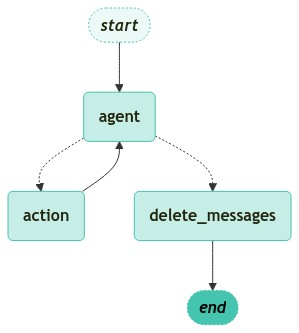

In [6]:
# 메시지 개수가 3개 초과 시 오래된 메시지 삭제 및 최신 메시지만 유지
def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}


# 메시지 상태에 따른 다음 실행 노드 결정 로직
def should_continue(state: MessagesState) -> Literal["action", "delete_messages"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # 함수 호출이 없는 경우 메시지 삭제 함수 실행
    if not last_message.tool_calls:
        return "delete_messages"
    # 함수 호출이 있는 경우 액션 실행
    return "action"


# 메시지 상태 기반 워크플로우 그래프 정의
workflow = StateGraph(MessagesState)

# 에이전트와 액션 노드 추가
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# 메시지 삭제 노드 추가
workflow.add_node(delete_messages)

# 시작 노드에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 조건부 엣지 추가를 통한 노드 간 흐름 제어
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

# 액션 노드에서 에이전트 노드로 연결
workflow.add_edge("action", "agent")

# 메시지 삭제 노드에서 종료 노드로 연결
workflow.add_edge("delete_messages", END)

# 메모리 체크포인터를 사용하여 워크플로우 컴파일
app = workflow.compile(checkpointer=memory)

visualize_graph(app)


In [7]:
# 스레드 ID가 포함된 설정 객체 초기화
config = {"configurable": {"thread_id": "2"}}

# 1번째 질문 수행
input_message = HumanMessage(
    content="안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다."
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.')]
[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?')]


In [8]:
# 2번째 질문 수행
input_message = HumanMessage(content="내 이름이 뭐라고요?")

for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?'), ('human', '내 이름이 뭐라고요?')]
[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?'), ('human', '내 이름이 뭐라고요?'), ('ai', 'Teddy님이시죠! 맞나요?')]
[('remove', ''), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?'), ('human', '내 이름이 뭐라고요?'), ('ai', 'Teddy님이시죠! 맞나요?')]


In [9]:
# 최종 상태를 확인해보면 메시지가 단 세 개만 있는 것을 확인할 수 있습니다. 

# 이는 이전 메시지들을 방금 삭제했기 때문입니다.

# 앱 상태에서 메시지 목록 추출 및 저장
messages = app.get_state(config).values["messages"]
# 메시지 목록 반환
for message in messages:
    message.pretty_print()

================================ Remove Message ================================


================================== Ai Message ==================================

안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

Teddy님이시죠! 맞나요?


# 9) ToolNode 를 사용하여 도구를 호출하는 방법

이번 튜토리얼에서는 도구 호출을 위한 LangGraph의 사전 구축된 `pre-built`의 `ToolNode` 사용 방법을 다룹니다.

`ToolNode`는 메시지 목록이 포함된 그래프 상태를 입력으로 받아 도구 호출 결과로 상태를 업데이트하는 LangChain Runnable입니다. 

이는 LangGraph의 사전 구축된 Agent 와 즉시 사용할 수 있도록 설계되었으며, 상태에 적절한 리듀서가 있는 `messages` 키가 포함된 경우 모든 `StateGraph` 와 함께 작동할 수 있습니다.

In [10]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [11]:
from langchain_core.tools import tool
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langchain_teddynote.tools import GoogleNews
from typing import List, Dict
from langgraph.prebuilt import ToolNode, tools_condition

# 도구 정의

# 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


@tool
def python_code_interpreter(code: str):
    """Call to execute python code."""
    return PythonAstREPLTool().invoke(code)

# 다음으로는 `ToolNode` 를 사용하여 도구를 호출하는 방법을 살펴보겠습니다.
# 도구 리스트 생성
tools = [search_news, python_code_interpreter]

# ToolNode 초기화
tool_node = ToolNode(tools)

c:\Users\user\anaconda3\envs\myenv\Lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


###  `ToolNode`를 수동으로 호출하기

`ToolNode`는 메시지 목록과 함께 그래프 상태에서 작동합니다. 

- **중요**: 이때 목록의 마지막 메시지는 `tool_calls` 속성을 포함하는 `AIMessage`여야 합니다.

먼저 도구 노드를 수동으로 호출하는 방법을 살펴보겠습니다.

In [12]:
from langchain_core.messages import AIMessage

# 단일 도구 호출을 포함하는 AI 메시지 객체 생성
# AIMessage 객체이어야 함
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",  # 도구 이름 <------이름 명시하여 지정해서 사용 가능
            "args": {"query": "AI"},  # 도구 인자
            "id": "tool_call_id",  # 도구 호출 ID
            "type": "tool_call",  # 도구 호출 유형
        }
    ],
)

# 도구 노드를 통한 메시지 처리 및 날씨 정보 요청 실행
tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE5zT3VxSkxjUW1fMEJVU3J6TVhFYkF4QkhZUC1KVHFmeXhNQk9UemVEQi1IVUdrbUV0S2FPdkZYWDVMZmczRnhVcTZzcVlQQk44MTg4emkyTG05d3ZiOTFhdVpyRHJwa2ExY3c?oc=5", "content": "\\uc624\\ud508AI, \\uac00\\uc7a5 \\ud070 AI \\ubaa8\\ub378 \'GPT-4.5\' \\uacf5\\uac1c...\\ube44\\ucd94\\ub860 \\ubaa8\\ub378 \\ud55c\\uacc4 \\ubcf4\\uc5ec\\uc918 - AI\\ud0c0\\uc784\\uc2a4"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE1KSUV3VUUwQThfWTlGMFBqLXJ2RnZxdWFNbmllQTVmVVVwc3ZDZVpvMXkyQVZsUjZjNG44TTJTdElibUpwQlFGZEJjcEhNV2ZtTmdGQ25haXV4OGvSAWBBVV95cUxQeTFzVC1kTkxuc1JHOUtLM25lUjV6b2hXcUs3V3NqQjFfWG1xWjlVZ3V1eFFCT2p2eWpwRE1aekpBX2ZJNnBHWHJoVm4yLXl2MnhtVmtTcVc5aGl5MTd6QVM?oc=5", "content": "\\uc624\\ud508AI, \\ucd5c\\uc2e0 AI \\ubaa8\\ub378 GPT-4.5 \\ucd9c\\uc2dc\\u2026\\"\\ub300\\ud654\\ud615 \\ubaa8\\ub378 \\ucd5c\\uac15\\" - \\uc5f0\\ud569\\ub274\\uc2a4"}, {"url": "https://news.google.com/rss/articles/CBMiggFBVV95cUxQQ

일반적으로 `AIMessage`를 수동으로 생성할 필요가 없으며, 도구 호출을 지원하는 모든 LangChain 채팅 모델에서 자동으로 생성됩니다.

또한 `AIMessage`의 `tol_callos` 매개변수에 여러 도구 호출을 전달하면 `ToolNode`를 사용하여 병렬 도구 호출을 수행할 수 있습니다.

In [13]:
# 다중 도구 호출을 포함하는 AI 메시지 객체 생성 및 초기화
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",
            "args": {"query": "AI"},
            "id": "tool_call_id",
            "type": "tool_call",
        },
        {
            "name": "python_code_interpreter",
            "args": {"code": "print(1+2+3+4)"},
            "id": "tool_call_id",
            "type": "tool_call",
        },
    ],
)

# 생성된 메시지를 도구 노드에 전달하여 다중 도구 호출 실행
tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE5zT3VxSkxjUW1fMEJVU3J6TVhFYkF4QkhZUC1KVHFmeXhNQk9UemVEQi1IVUdrbUV0S2FPdkZYWDVMZmczRnhVcTZzcVlQQk44MTg4emkyTG05d3ZiOTFhdVpyRHJwa2ExY3c?oc=5", "content": "\\uc624\\ud508AI, \\uac00\\uc7a5 \\ud070 AI \\ubaa8\\ub378 \'GPT-4.5\' \\uacf5\\uac1c...\\ube44\\ucd94\\ub860 \\ubaa8\\ub378 \\ud55c\\uacc4 \\ubcf4\\uc5ec\\uc918 - AI\\ud0c0\\uc784\\uc2a4"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE1KSUV3VUUwQThfWTlGMFBqLXJ2RnZxdWFNbmllQTVmVVVwc3ZDZVpvMXkyQVZsUjZjNG44TTJTdElibUpwQlFGZEJjcEhNV2ZtTmdGQ25haXV4OGvSAWBBVV95cUxQeTFzVC1kTkxuc1JHOUtLM25lUjV6b2hXcUs3V3NqQjFfWG1xWjlVZ3V1eFFCT2p2eWpwRE1aekpBX2ZJNnBHWHJoVm4yLXl2MnhtVmtTcVc5aGl5MTd6QVM?oc=5", "content": "\\uc624\\ud508AI, \\ucd5c\\uc2e0 AI \\ubaa8\\ub378 GPT-4.5 \\ucd9c\\uc2dc\\u2026\\"\\ub300\\ud654\\ud615 \\ubaa8\\ub378 \\ucd5c\\uac15\\" - \\uc5f0\\ud569\\ub274\\uc2a4"}, {"url": "https://news.google.com/rss/articles/CBMiggFBVV95cUxQQ

### llm 과 함께 사용하기

도구 호출 기능이 있는 채팅 모델을 사용하기 위해서는 먼저 모델이 사용 가능한 도구들을 인식하도록 해야 합니다. 

이는 `ChatOpenAI` 모델에서 `.bind_tools` 메서드를 호출하여 수행합니다.

In [14]:
# LLM 모델 초기화 및 도구 바인딩
model_with_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

In [15]:
# 도구 호출 확인
model_with_tools.invoke("처음 5개의 소수를 출력하는 python code 를 작성해줘").tool_calls

[{'name': 'python_code_interpreter',
  'args': {'code': 'def first_n_primes(n):\n    primes = []\n    num = 2  # Starting from the first prime number\n    while len(primes) < n:\n        is_prime = True\n        for i in range(2, int(num**0.5) + 1):\n            if num % i == 0:\n                is_prime = False\n                break\n        if is_prime:\n            primes.append(num)\n        num += 1\n    return primes\n\n# Get the first 5 prime numbers\nfirst_n_primes(5)'},
  'id': 'call_yDgiERfBzf9ml2LGBA13vFFr',
  'type': 'tool_call'}]

- 보시다시피 채팅 모델이 생성한 AI 메시지에는 이미 `tool_calls`가 채워져 있으므로, 이를 `ToolNode`에 직접 전달할 수 있습니다.
- 위에서 ToolNode를 수동으로 호출하기 위해 tool_calls 넣어준 것과 같음

In [16]:
# 도구 노드를 통한 메시지 처리 및 LLM 모델의 도구 기반 응답 생성
tool_node.invoke(
    {
        "messages": [
            model_with_tools.invoke(
                "처음 5개의 소수를 출력하는 python code 를 작성해줘"
            )
        ]
    }
)

{'messages': [ToolMessage(content='[2, 3, 5, 7, 11]', name='python_code_interpreter', tool_call_id='call_BMjg9OdoJsclgobu2J3R4MeT')]}

### Agent 와 함께 사용하기

다음으로, LangGraph 그래프 내에서 `ToolNode`를 사용하는 방법을 살펴보겠습니다. 

Agent 의 그래프 구현을 설정해보겠습니다. 이 **Agent** 는 쿼리를 입력으로 받아, 쿼리를 해결하는 데 필요한 충분한 정보를 얻을 때까지 반복적으로 도구들을 호출합니다. 

방금 정의한 도구들과 함께 `ToolNode` 및 OpenAI 모델을 사용하게 됩니다.

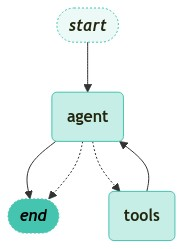

In [17]:
# LangGraph 워크플로우 상태 및 메시지 처리를 위한 타입 임포트
from langgraph.graph import StateGraph, MessagesState, START, END


# LLM 모델을 사용하여 메시지 처리 및 응답 생성, 도구 호출이 포함된 응답 반환
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


# 메시지 상태 기반 워크플로우 그래프 초기화
workflow = StateGraph(MessagesState)

# 에이전트와 도구 노드 정의 및 워크플로우 그래프에 추가
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 워크플로우 시작점에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 에이전트 노드에서 조건부 분기 설정, 도구 노드 또는 종료 지점으로 연결
workflow.add_conditional_edges("agent", tools_condition)

# 도구 노드에서 에이전트 노드로 순환 연결
workflow.add_edge("tools", "agent")

# 에이전트 노드에서 종료 지점으로 연결
workflow.add_edge("agent", END)


# 정의된 워크플로우 그래프 컴파일 및 실행 가능한 애플리케이션 생성
app = workflow.compile()

visualize_graph(app)

In [18]:
# 실행 및 결과 확인
for chunk in app.stream(
    {"messages": [("human", "처음 5개의 소수를 출력하는 python code 를 작성해줘")]},
    stream_mode="values",
):
    # 마지막 메시지 출력
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

처음 5개의 소수를 출력하는 python code 를 작성해줘
================================== Ai Message ==================================
Tool Calls:
  python_code_interpreter (call_dRzshEwCjt8VuCbQdb772Mhr)
 Call ID: call_dRzshEwCjt8VuCbQdb772Mhr
  Args:
    code: def first_n_primes(n):
    primes = []
    num = 2  # Starting from the first prime number
    while len(primes) < n:
        is_prime = True
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                is_prime = False
                break
        if is_prime:
            primes.append(num)
        num += 1
    return primes

# Get the first 5 prime numbers
first_n_primes(5)
================================= Tool Message =================================
Name: python_code_interpreter

[2, 3, 5, 7, 11]
================================== Ai Message ==================================

처음 5개의 소수는 다음과 같습니다: [2, 3, 5, 7, 11]


In [19]:
# 검색 질문 수행
for chunk in app.stream(
    {"messages": [("human", "search google news about AI")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

search google news about AI
================================== Ai Message ==================================
Tool Calls:
  search_news (call_HKDIXkzkvxSRh8QlRutDd9xe)
 Call ID: call_HKDIXkzkvxSRh8QlRutDd9xe
  Args:
    query: AI
================================= Tool Message =================================
Name: search_news

[{"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE5zT3VxSkxjUW1fMEJVU3J6TVhFYkF4QkhZUC1KVHFmeXhNQk9UemVEQi1IVUdrbUV0S2FPdkZYWDVMZmczRnhVcTZzcVlQQk44MTg4emkyTG05d3ZiOTFhdVpyRHJwa2ExY3c?oc=5", "content": "\uc624\ud508AI, \uac00\uc7a5 \ud070 AI \ubaa8\ub378 'GPT-4.5' \uacf5\uac1c...\ube44\ucd94\ub860 \ubaa8\ub378 \ud55c\uacc4 \ubcf4\uc5ec\uc918 - AI\ud0c0\uc784\uc2a4"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE1KSUV3VUUwQThfWTlGMFBqLXJ2RnZxdWFNbmllQTVmVVVwc3ZDZVpvMXkyQVZsUjZjNG44TTJTdElibUpwQlFGZEJjcEhNV2ZtTmdGQ25haXV4OGvSAWBBVV95cUxQeTFzVC1kTkxuc1JHOUtLM2

In [20]:
# 도구 호출이 필요 없는 질문 수행
for chunk in app.stream(
    {"messages": [("human", "안녕? 반가워")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

안녕? 반가워
================================== Ai Message ==================================

안녕하세요! 반가워요. 어떻게 도와드릴까요?


- `ToolNode`는 도구 실행 중 발생하는 오류도 처리할 수 있습니다. 

- `handle_tool_errors=True`를 설정하여 이 기능을 활성화/비활성화할 수 있습니다(기본적으로 활성화되어 있음)

# 10) 병렬 노드 실행을 위한 분기 생성 방법

![](image/langgraph-09.jpeg)

노드의 병렬 실행은 전체 그래프 작업의 속도를 향상시키는 데 필수적입니다. `LangGraph`는 노드의 병렬 실행을 기본적으로 지원하며, 이는 그래프 기반 워크플로우의 성능을 크게 향상시킬 수 있습니다. 

이러한 병렬화는 **fan-out**과 **fan-in** 메커니즘을 통해 구현되며, 표준 엣지와 `conditional_edges` 를 활용합니다. 

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

## 병렬 노드 fan-out 및 fan-in

**fan-out / fan-in**

병렬 처리에서 **fan-out**과 **fan-in**은 작업을 나누고 모으는 과정을 설명하는 개념입니다.

- **Fan-out (확장)**: 큰 작업을 여러 작은 작업으로 쪼갭니다. 예를 들어, 피자를 만들 때 도우, 소스, 치즈 준비를 각각 별도로 할 수 있습니다. 이렇게 각각의 파트를 나눠 동시에 처리하는 것이 fan-out입니다.

- **Fan-in (수집)**: 나뉜 작은 작업들을 다시 하나로 합칩니다. 피자에 준비된 재료들을 모두 올려 완성 피자를 만드는 과정처럼, 여러 작업이 끝나면 결과를 모아 최종 작업을 완성하는 것이 fan-in입니다.

즉, **fan-out**으로 작업을 분산시키고, **fan-in**으로 결과를 합쳐 최종 결과를 얻는 흐름입니다.

----

이 예시에서는 `Node A`에서 `B and C`로 팬아웃하고 `D`로 팬인하는 과정을 보여줍니다. 

State에서는 `reducer(add)` 연산자를 지정합니다. 이는 State 내 특정 키의 기존 값을 단순히 덮어쓰는 대신 값들을 결합하거나 누적합니다. 리스트의 경우, 새로운 리스트를 기존 리스트와 연결하는 것을 의미합니다.

LangGraph는 State의 특정 키에 대한 reducer 함수를 지정하기 위해 `Annotated` 타입을 사용합니다. 이는 타입 검사를 위해 원래 타입(`list`)을 유지하면서도, 타입 자체를 변경하지 않고 reducer 함수(`add`)를 타입에 첨부할 수 있게 합니다.

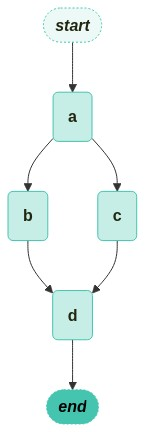

In [2]:
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# 노드 값 반환 클래스
class ReturnNodeValue:
    # 초기화
    def __init__(self, node_secret: str):
        self._value = node_secret

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)

# 노드 A부터 D까지 생성 및 값 할당
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# 노드 연결
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

# 그래프 컴파일
graph = builder.compile()

from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [4]:
# 그래프 실행
# `reducer`를 통해 각 노드에 추가된 값들이 **누적**되는 것을 확인할 수 있습니다.

graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", id='55835ad6-97eb-44ce-8649-f36c0a57aada')]
Adding I'm C to [HumanMessage(content="I'm A", id='55835ad6-97eb-44ce-8649-f36c0a57aada')]
Adding I'm D to [HumanMessage(content="I'm A", id='55835ad6-97eb-44ce-8649-f36c0a57aada'), HumanMessage(content="I'm B", id='9887ae4e-7fbf-4ed7-9250-52cec57410dd'), HumanMessage(content="I'm C", id='60ae6921-26ce-46ac-bb2a-016088a1543d')]


{'aggregate': [HumanMessage(content="I'm A", id='55835ad6-97eb-44ce-8649-f36c0a57aada'),
  HumanMessage(content="I'm B", id='9887ae4e-7fbf-4ed7-9250-52cec57410dd'),
  HumanMessage(content="I'm C", id='60ae6921-26ce-46ac-bb2a-016088a1543d'),
  HumanMessage(content="I'm D", id='bcfd354e-efff-43d9-839c-8eb5a9820f20')]}

### 병렬처리 중 예외 발생시 대응

LangGraph는 "superstep(여러 노드들이 처리되는 전체 프로세스 스텝)" 내에서 노드를 실행하는데, 이는 병렬 분기가 동시에 실행되더라도 전체 superstep이 **트랜잭션** 방식으로 처리됨을 의미합니다. 

따라서, 이러한 분기 중 하나라도 예외가 발생하면, 상태에 대한 업데이트가 **전혀** 적용되지 않습니다(전체 superstep이 오류 처리됨).

> superstep: 여러 노드들이 처리되는 전체 프로세스 스텝

![](image/langgraph-09.jpeg)

오류가 발생하기 쉬운 작업(예: 불안정한 API 호출 처리)이 있는 경우, LangGraph는 이를 해결하기 위한 두 가지 방법을 제공합니다.

1. 노드 내에서 일반적인 Python 코드를 작성하여 예외를 포착하고 처리할 수 있습니다.
2. **[retry_policy](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.retry_policy)** 를 설정하여 특정 유형의 예외가 발생한 노드를 재시도하도록 그래프를 지시할 수 있습니다. 실패한 분기만 재시도되므로 불필요한 작업 수행에 대해 걱정할 필요가 없습니다.

이러한 기능들을 통해 병렬 실행과 예외 처리를 완벽하게 제어할 수 있습니다.

## 추가 단계가 있는 병렬 노드의 fan-out 및 fan-in

위의 예시에서는 각 경로가 단일 단계일 때의 `fan-out`과 `fan-in` 방법을 보여주었습니다. 하지만 하나의 경로에 여러 단계가 있다면 어떻게 될까요?

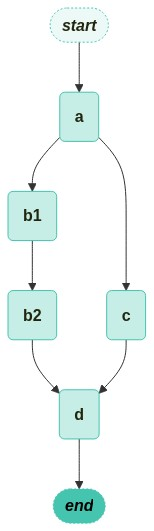

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# 노드 값 반환 클래스
class ReturnNodeValue:
    # 초기화
    def __init__(self, node_secret: str):
        self._value = node_secret

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)

# 노드 생성 및 연결
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b1", ReturnNodeValue("I'm B1"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b1")
builder.add_edge("a", "c")
builder.add_edge("b1", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

# 그래프 컴파일
graph = builder.compile()

from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [6]:
# 빈 리스트를 사용한 그래프 집계 연산 실행, 모든 데이터에 대한 기본 집계 수행
graph.invoke({"aggregate": []})

Adding I'm A to []
Adding I'm B1 to [HumanMessage(content="I'm A", id='5c75d93e-f391-4b6a-9058-5abf72f9f674')]
Adding I'm C to [HumanMessage(content="I'm A", id='5c75d93e-f391-4b6a-9058-5abf72f9f674')]
Adding I'm B2 to [HumanMessage(content="I'm A", id='5c75d93e-f391-4b6a-9058-5abf72f9f674'), HumanMessage(content="I'm B1", id='69dac63a-0028-46ba-ba13-635f0e3c977b'), HumanMessage(content="I'm C", id='fb35f4c9-87d3-4a93-9ba8-a4e7146b53d9')]
Adding I'm D to [HumanMessage(content="I'm A", id='5c75d93e-f391-4b6a-9058-5abf72f9f674'), HumanMessage(content="I'm B1", id='69dac63a-0028-46ba-ba13-635f0e3c977b'), HumanMessage(content="I'm C", id='fb35f4c9-87d3-4a93-9ba8-a4e7146b53d9'), HumanMessage(content="I'm B2", id='7709752e-7ddf-42cd-96c6-cfb4ec02cb40')]


{'aggregate': [HumanMessage(content="I'm A", id='5c75d93e-f391-4b6a-9058-5abf72f9f674'),
  HumanMessage(content="I'm B1", id='69dac63a-0028-46ba-ba13-635f0e3c977b'),
  HumanMessage(content="I'm C", id='fb35f4c9-87d3-4a93-9ba8-a4e7146b53d9'),
  HumanMessage(content="I'm B2", id='7709752e-7ddf-42cd-96c6-cfb4ec02cb40'),
  HumanMessage(content="I'm D", id='2f997bbe-8eb4-4553-9785-3af99034315e')]}

## 조건부 분기(conditional branching)

fan-out이 결정적이지 않은 경우, `add_conditional_edges` 를 직접 사용할 수 있습니다.

조건부 분기 이후 연결될 알려진 "sink" 노드가 있는 경우, 조건부 엣지를 생성할 때 `then="실행할 노드명"` 을 제공할 수 있습니다.

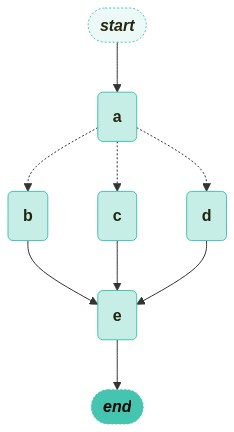

In [7]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]
    which: str


# 노드별 고유 값을 반환하는 클래스
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


# 상태의 'which' 값에 따른 조건부 라우팅 경로 결정 함수
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# 전체 병렬 처리할 노드 목록
intermediates = ["b", "c", "d"]

builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")


# 최종 노드 연결 및 그래프 컴파일
builder.add_edge("e", END)
graph = builder.compile()

from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [8]:
# 그래프 실행(which: bc 로 지정)
graph.invoke({"aggregate": [], "which": "bc"})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", id='adc87278-24a9-41b7-a6e9-8aad75bc6840')]
Adding I'm C to [HumanMessage(content="I'm A", id='adc87278-24a9-41b7-a6e9-8aad75bc6840')]
Adding I'm E to [HumanMessage(content="I'm A", id='adc87278-24a9-41b7-a6e9-8aad75bc6840'), HumanMessage(content="I'm B", id='1f823e83-2da4-4b59-9fa5-af6c8908598a'), HumanMessage(content="I'm C", id='ba41a81f-83fb-4149-8b6f-9247118a7cfa')]


{'aggregate': [HumanMessage(content="I'm A", id='adc87278-24a9-41b7-a6e9-8aad75bc6840'),
  HumanMessage(content="I'm B", id='1f823e83-2da4-4b59-9fa5-af6c8908598a'),
  HumanMessage(content="I'm C", id='ba41a81f-83fb-4149-8b6f-9247118a7cfa'),
  HumanMessage(content="I'm E", id='69f68790-4785-4dbf-a699-07990b73caf9')],
 'which': 'bc'}

In [9]:
# 그래프 실행(which: cd 로 지정)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", id='cd69af50-5dec-4e7e-adbb-03fc8139ffdb')]
Adding I'm D to [HumanMessage(content="I'm A", id='cd69af50-5dec-4e7e-adbb-03fc8139ffdb')]
Adding I'm E to [HumanMessage(content="I'm A", id='cd69af50-5dec-4e7e-adbb-03fc8139ffdb'), HumanMessage(content="I'm C", id='71bdbeed-6586-4fa7-96e3-c1644e110b50'), HumanMessage(content="I'm D", id='5f66fbec-be3a-4641-b08b-9b770a9d40a4')]


{'aggregate': [HumanMessage(content="I'm A", id='cd69af50-5dec-4e7e-adbb-03fc8139ffdb'),
  HumanMessage(content="I'm C", id='71bdbeed-6586-4fa7-96e3-c1644e110b50'),
  HumanMessage(content="I'm D", id='5f66fbec-be3a-4641-b08b-9b770a9d40a4'),
  HumanMessage(content="I'm E", id='e17a52f4-dbae-4845-abff-df6c75182da7')],
 'which': 'cd'}

## fan-out 값의 신뢰도에 따른 정렬

병렬로 펼쳐진 노드들은 하나의 "**super-step**"으로 실행됩니다. 각 super-step 에서 발생한 업데이트들은 해당 super-step 이 완료된 후 순차적으로 상태에 적용됩니다.

병렬 super-step 에서 일관된 사전 정의된 업데이트 순서가 필요한 경우, 출력값을 식별 키와 함께 상태의 별도 필드에 기록한 다음, 팬아웃된 각 노드에서 집결 지점까지 일반 `edge` 를 추가하여 "sink" 노드에서 이들을 결합해야 합니다.

예를 들어, 병렬 단계의 출력을 "신뢰도"에 따라 정렬하고자 하는 경우를 고려해보겠습니다.

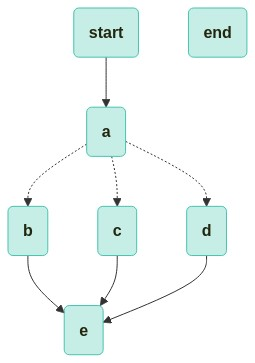

In [11]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# 팬아웃 값들의 병합 로직 구현, 빈 리스트 처리 및 리스트 연결 수행
def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        # 덮어쓰기
        return []
    return left + right


# 상태 관리를 위한 타입 정의, 집계 및 팬아웃 값 저장 구조 설정
class State(TypedDict):
    # add_messages 리듀서 사용
    aggregate: Annotated[list, add_messages]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str


# 그래프 초기화
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")


# 병렬 노드 값 반환 클래스
class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }


# 신뢰도(reliability)가 다른 병렬 노드들 추가
builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.1))
builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.9))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.5))


# 팬아웃 값들을 신뢰도 기준으로 정렬하고 최종 집계 수행
def aggregate_fanout_values(state: State) -> Any:
    # 신뢰도 기준 정렬
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    print(ranked_values)
    return {
        "aggregate": [x["value"][0] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }


# 집계 노드 추가
builder.add_node("e", aggregate_fanout_values)


# 상태에 따른 조건부 라우팅 로직 구현
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# 중간 노드들 설정 및 조건부 엣지 추가
intermediates = ["b", "c", "d"]
builder.add_conditional_edges("a", route_bc_or_cd, intermediates)

# 중간 노드들과 최종 집계 노드 연결
for node in intermediates:
    builder.add_edge(node, "e")

# 그래프 완성을 위한 최종
graph = builder.compile()

from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

#### 병렬로 노드 실행시 결과를 reliability 기준으로 정렬합니다.

**참고**

- `b`: reliability=0.1
- `c`: reliability=0.9
- `d`: reliability=0.5

In [12]:
# 그래프 실행(which: bc 로 지정)
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", id='fd8e6279-0633-4775-9d32-3191ba9fb456')] in parallel.
Adding I'm C to [HumanMessage(content="I'm A", id='fd8e6279-0633-4775-9d32-3191ba9fb456')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm B"], 'reliability': 0.1}]


{'aggregate': [HumanMessage(content="I'm A", id='fd8e6279-0633-4775-9d32-3191ba9fb456'),
  HumanMessage(content="I'm C", id='510223af-658c-4488-9e80-5f2d9466e177'),
  HumanMessage(content="I'm B", id='8b5e9b2d-8c5f-42af-a3ae-4bfb4951fd2b'),
  HumanMessage(content="I'm E", id='54ec18c3-bd43-4f68-9a32-c2678a534500')],
 'fanout_values': [],
 'which': 'bc'}

In [13]:
# 그래프 실행(which: cd 로 지정)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", id='8580bae6-3f96-4318-9fa8-176c7c6674f4')] in parallel.
Adding I'm D to [HumanMessage(content="I'm A", id='8580bae6-3f96-4318-9fa8-176c7c6674f4')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm D"], 'reliability': 0.5}]


{'aggregate': [HumanMessage(content="I'm A", id='8580bae6-3f96-4318-9fa8-176c7c6674f4'),
  HumanMessage(content="I'm C", id='f1d64bce-11cf-4c51-96a6-5b805340b5f7'),
  HumanMessage(content="I'm D", id='2f23d460-f6f4-4d34-99f6-ce8eeb21b701'),
  HumanMessage(content="I'm E", id='16d46587-1ef3-42a8-b0af-183795d30d44')],
 'fanout_values': [],
 'which': 'cd'}

# 11) 대화 기록 요약을 추가하는 방법

![](image/langgraph-10.jpeg)

대화 기록을 유지하는 것은 **지속성**의 가장 일반적인 사용 사례 중 하나입니다. 이는 대화를 지속하기 쉽게 만들어주는 장점이 있습니다. 

하지만 대화가 길어질수록 대화 기록이 누적되어 `context window`를 더 많이 차지하게 됩니다. 이는 `LLM` 호출이 더 비싸고 길어지며, 잠재적으로 오류가 발생할 수 있어 바람직하지 않을 수 있습니다. 이를 해결하기 위한 한 가지 방법은 현재까지의 대화 요약본을 생성하고, 이를 최근 `N` 개의 메시지와 함께 사용하는 것입니다. 

이 가이드에서는 이를 구현하는 방법의 예시를 살펴보겠습니다.

다음과 같은 단계가 필요합니다.

- 대화가 너무 긴지 확인 (메시지 수나 메시지 길이로 확인 가능)
- 너무 길다면 요약본 생성 (이를 위한 프롬프트 필요)
- 마지막 `N` 개의 메시지를 제외한 나머지 삭제

이 과정에서 중요한 부분은 오래된 메시지를 삭제(`DeleteMessage`) 하는 것입니다. 

## 긴 대화를 요약하여 대화로 저장

긴 대화에 대하여 요약본을 생성한 뒤, 기존의 대화를 삭제하고 요약본을 대화로 저장합니다.

**조건**

- 대화의 길이가 6개 초과일 경우 요약본을 생성

In [14]:
from typing import Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.graph.message import add_messages

# 메모리 저장소 설정
memory = MemorySaver()


# 메시지 상태와 요약 정보를 포함하는 상태 클래스
class State(MessagesState):
    messages: Annotated[list, add_messages]
    summary: str


# 대화 및 요약을 위한 모델 초기화
model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

`ask_llm` 노드는 `messages` 를 llm 에 주입하여 답변을 얻습니다.

만약, **이전의 대화 요약본**이 존재한다면, 이를 시스템 메시지로 추가하여 대화에 포함시킵니다.

하지만, 이전의 대화 요약본이 존재하지 않는다면, 이전의 대화 내용만 사용합니다.

In [15]:
def ask_llm(state: State):
    # 이전 요약 정보 확인
    summary = state.get("summary", "")

    # 이전 요약 정보가 있다면 시스템 메시지로 추가
    if summary:
        # 시스템 메시지 생성
        system_message = f"Summary of conversation earlier: {summary}"
        # 시스템 메시지와 이전 메시지 결합
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        # 이전 메시지만 사용
        messages = state["messages"]

    # 모델 호출
    response = model.invoke(messages)

    # 응답 반환
    return {"messages": [response]}

`should_continue` 노드는 대화의 길이가 6개 초과일 경우 요약 노드로 이동합니다.

그렇지 않다면, 즉각 답변을 반환합니다. (`END` 노드로 이동)

In [16]:
from langgraph.graph import END


# 대화 종료 또는 요약 결정 로직
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    # 메시지 목록 확인
    messages = state["messages"]

    # 메시지 수가 6개 초과라면 요약 노드로 이동
    if len(messages) > 6:
        return "summarize_conversation"
    return END

`summarize_conversation` 노드는 대화 내용을 요약하고, 오래된 메시지를 삭제합니다.

In [17]:
# 대화 내용 요약 및 메시지 정리 로직
def summarize_conversation(state: State):
    # 이전 요약 정보 확인
    summary = state.get("summary", "")

    # 이전 요약 정보가 있다면 요약 메시지 생성
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above in Korean:"
        )
    else:
        # 요약 메시지 생성
        summary_message = "Create a summary of the conversation above in Korean:"

    # 요약 메시지와 이전 메시지 결합
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    # 모델 호출
    response = model.invoke(messages)
    # 오래된 메시지 삭제
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    # 요약 정보 반환
    return {"summary": response.content, "messages": delete_messages}

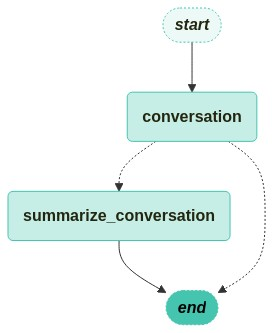

In [18]:
# 워크플로우 그래프 초기화
workflow = StateGraph(State)

# 대화 및 요약 노드 추가
workflow.add_node("conversation", ask_llm)
workflow.add_node(summarize_conversation)

# 시작점을 대화 노드로 설정
workflow.add_edge(START, "conversation")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "conversation",
    should_continue,
)

# 요약 노드에서 종료 노드로의 엣지 추가
workflow.add_edge("summarize_conversation", END)

# 워크플로우 컴파일 및 메모리 체크포인터 설정
app = workflow.compile(checkpointer=memory)

from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [19]:
# 업데이트 정보 출력 함수
def print_update(update):
    # 업데이트 딕셔너리 순회
    for k, v in update.items():
        # 메시지 목록 출력
        for m in v["messages"]:
            m.pretty_print()
        # 요약 정보 존재 시 출력
        if "summary" in v:
            print(v["summary"])

# 메시지 핸들링을 위한 HumanMessage 클래스 임포트
from langchain_core.messages import HumanMessage

# 스레드 ID가 포함된 설정 객체 초기화
config = {"configurable": {"thread_id": "1"}}

# 첫 번째 사용자 메시지 생성 및 출력
input_message = HumanMessage(content="안녕하세요? 반갑습니다. 제 이름은 테디입니다.")
input_message.pretty_print()

# 스트림 모드에서 첫 번째 메시지 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# 두 번째 사용자 메시지 생성 및 출력
input_message = HumanMessage(content="제 이름이 뭔지 기억하세요?")
input_message.pretty_print()

# 스트림 모드에서 두 번째 메시지 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# 세 번째 사용자 메시지 생성 및 출력
input_message = HumanMessage(content="제 직업은 AI 연구원이에요")
input_message.pretty_print()

# 스트림 모드에서 세 번째 메시지 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

안녕하세요? 반갑습니다. 제 이름은 테디입니다.
================================== Ai Message ==================================

안녕하세요, 테디님! 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

제 이름이 뭔지 기억하세요?
================================== Ai Message ==================================

네, 테디님이라고 하셨습니다! 어떻게 도와드릴까요?
================================ Human Message =================================

제 직업은 AI 연구원이에요
================================== Ai Message ==================================

멋진 직업이네요, 테디님! AI 연구원으로서 어떤 분야에 주로 관심이 있으신가요? 또는 현재 진행 중인 프로젝트가 있으신가요?


지금까지는 요약이 전혀 이루어지지 않은 것을 확인할 수 있습니다 - 이는 목록에 메시지가 6개밖에 없기 때문입니다.

In [20]:
# 상태 구성 값 검색
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='안녕하세요? 반갑습니다. 제 이름은 테디입니다.', id='8c58bb1a-2dab-4b35-a3d8-8d2b10a69c9c'),
  AIMessage(content='안녕하세요, 테디님! 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 21, 'total_tokens': 40, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-4d5afb89-b5b0-4269-9d22-28bde1204de0-0', usage_metadata={'input_tokens': 21, 'output_tokens': 19, 'total_tokens': 40}),
  HumanMessage(content='제 이름이 뭔지 기억하세요?', id='246b5215-56f6-448b-b6e8-44da689eaa4d'),
  AIMessage(content='네, 테디님이라고 하셨습니다! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt

In [21]:
# 이제 다른 메시지를 보내보겠습니다

# 사용자 입력 메시지 객체 생성
input_message = HumanMessage(
    content="최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다."
)

# 메시지 내용 출력
input_message.pretty_print()

# 스트림 이벤트 실시간 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다.
================================== Ai Message ==================================

LLM(대규모 언어 모델)에 대한 연구는 정말 흥미로운 분야입니다! 최근 몇 년 동안 많은 발전이 있었고, 다양한 논문들이 발표되고 있습니다. 어떤 특정한 주제나 질문이 있으신가요? 아니면 추천할 만한 논문이나 자료를 원하시는 건가요?
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


대화 요약:

사용자는 자신을 테디라고 소개하며, AI 연구원이라고 말했습니다. 테디는 최근 LLM(대규모 언어 모델)에 대해 더 알아보고 있으며, 관련 논문을 읽고 있다고 언급했습니다.


C:\Users\user\AppData\Local\Temp\ipykernel_20364\770844521.py:21: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]


현재 상태를 확인하면 대화의 요약과 함께 마지막 두 개의 메시지를 볼 수 있습니다.

In [22]:
# 상태 구성 값 검색
values = app.get_state(config).values
values

{'messages': [RemoveMessage(content='', id='8c58bb1a-2dab-4b35-a3d8-8d2b10a69c9c'),
  RemoveMessage(content='', id='run-4d5afb89-b5b0-4269-9d22-28bde1204de0-0'),
  RemoveMessage(content='', id='246b5215-56f6-448b-b6e8-44da689eaa4d'),
  RemoveMessage(content='', id='run-57029a80-4b7a-4620-bab7-b8b41fa203a4-0'),
  RemoveMessage(content='', id='a8441068-15b2-4756-8456-b850ed6b8b41'),
  RemoveMessage(content='', id='run-4a0ad0cc-7f04-49b9-97e6-c7b83d098af2-0'),
  HumanMessage(content='최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다.', id='fd0076c1-564d-47aa-ac8a-39f345bf9f2a'),
  AIMessage(content='LLM(대규모 언어 모델)에 대한 연구는 정말 흥미로운 분야입니다! 최근 몇 년 동안 많은 발전이 있었고, 다양한 논문들이 발표되고 있습니다. 어떤 특정한 주제나 질문이 있으신가요? 아니면 추천할 만한 논문이나 자료를 원하시는 건가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 163, 'total_tokens': 234, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'au

In [23]:
messages = values["messages"]
messages

[RemoveMessage(content='', id='8c58bb1a-2dab-4b35-a3d8-8d2b10a69c9c'),
 RemoveMessage(content='', id='run-4d5afb89-b5b0-4269-9d22-28bde1204de0-0'),
 RemoveMessage(content='', id='246b5215-56f6-448b-b6e8-44da689eaa4d'),
 RemoveMessage(content='', id='run-57029a80-4b7a-4620-bab7-b8b41fa203a4-0'),
 RemoveMessage(content='', id='a8441068-15b2-4756-8456-b850ed6b8b41'),
 RemoveMessage(content='', id='run-4a0ad0cc-7f04-49b9-97e6-c7b83d098af2-0'),
 HumanMessage(content='최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다.', id='fd0076c1-564d-47aa-ac8a-39f345bf9f2a'),
 AIMessage(content='LLM(대규모 언어 모델)에 대한 연구는 정말 흥미로운 분야입니다! 최근 몇 년 동안 많은 발전이 있었고, 다양한 논문들이 발표되고 있습니다. 어떤 특정한 주제나 질문이 있으신가요? 아니면 추천할 만한 논문이나 자료를 원하시는 건가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 163, 'total_tokens': 234, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'acc

이제 대화를 재개할 수 있습니다.

마지막 두 개의 메시지만 있더라도 이전 대화 내용에 대해 질문할 수 있습니다 (이전 내용이 요약되어 있기 때문입니다).

In [24]:
# 사용자 메시지 객체 생성
input_message = HumanMessage(content="제 이름이 무엇인지 기억하세요?")

# 메시지 내용 출력
input_message.pretty_print()

# 스트림 이벤트 실시간 처리 및 업데이트
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

제 이름이 무엇인지 기억하세요?


TypeError: Got unknown type content='' id='8c58bb1a-2dab-4b35-a3d8-8d2b10a69c9c'

# 12) 서브그래프 추가 및 사용 방법

SubGraph 를 사용하면 여러 구성 요소를 포함하는 복잡한 시스템을 구축할 수 있으며, 이러한 구성 요소 자체가 그래프가 될 수 있습니다. SubGraph 의 일반적인 사용 사례는 멀티 에이전트 시스템 구축입니다.

SubGraph 를 추가할 때 주요 고려사항은 상위 그래프와 SubGraph 가 어떻게 통신하는지, 즉 그래프 실행 중에 상태(State) 를 서로 어떻게 전달하는지입니다. 

다음 두 가지 시나리오가 있습니다.

* 상위 그래프와 서브그래프가 **스키마 키를 공유**하는 경우. 이 경우 **컴파일된 서브그래프로 노드를 추가** 할 수 있습니다
* 상위 그래프와 서브그래프가 **서로 다른 스키마**를 가지는 경우. 이 경우 **서브그래프를 호출하는 노드 함수를 추가** 해야 합니다. 
 
이는 상위 그래프와 서브그래프가 서로 다른 상태 스키마를 가지고 있고 서브그래프를 호출하기 전후에 상태를 변환해야 할 때 유용합니다.

아래에서 각 시나리오에 대한 서브그래프 추가 방법을 보여드리겠습니다.

## Case 1: 스키마 키를 공유하는 경우 -> state 안에 있는 키를 공유하는 경우

- 컴파일된 SubGraph 로 노드 추가하기

상위 그래프와 서브그래프가 공유 상태 키(State Key) 를 통해 통신하는 것이 일반적인 사례입니다. 

예를 들어, **멀티 에이전트 시스템** 에서 에이전트들은 주로 공유된 `messages` 키를 통해 통신합니다.

서브그래프가 상위 그래프와 상태 키를 공유하는 경우, 다음 단계에 따라 그래프에 추가할 수 있습니다.

1. 서브그래프 워크플로우를 정의하고(아래 예시의 `subgraph_builder`) 컴파일
2. 상위 그래프 워크플로우를 정의할 때 `.add_node` 메서드에 컴파일된 서브그래프 전달

그럼, 아래에서 간단한 예시를 살펴보겠습니다.

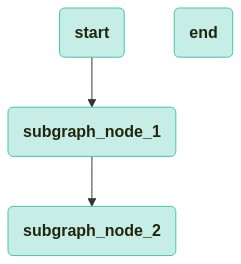

In [3]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

from langgraph.graph import START, END, StateGraph
from typing import TypedDict


# 서브그래프 상태 정의를 위한 TypedDict 클래스, 부모 그래프와 공유되는 name 키와 서브그래프 전용 family_name 키 포함
class ChildState(TypedDict):
    name: str  # 부모 그래프와 공유되는 상태 키
    family_name: str


# 서브그래프의 첫 번째 노드, family_name 키에 초기값 설정
def subgraph_node_1(state: ChildState):
    return {"family_name": "Lee"}


# 서브그래프의 두 번째 노드, 서브그래프 전용 family_name 키와 공유 name 키를 결합하여 새로운 상태 생성
def subgraph_node_2(state: ChildState):
    # 서브그래프 내부에서만 사용 가능한 family_name 키와 공유 상태 키 name를 사용하여 업데이트 수행
    return {"name": f'{state["name"]} {state["family_name"]}'}


# 서브그래프 구조 정의 및 노드 간 연결 관계 설정
subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

from langchain_teddynote.graphs import visualize_graph

visualize_graph(subgraph, xray=True)

In [ ]:
# 부모 그래프의 상태 정의를 위한 TypedDict 클래스, name 키만 포함
class ParentState(TypedDict):
    name: str   # <---------------서브 그래프와 state 이름 똑같음
    company: str


# 부모 그래프의 첫 번째 노드, name 키의 값을 수정하여 새로운 상태 생성
def node_1(state: ParentState):
    return {"name": f'My name is {state["name"]}'}


# 부모 그래프 구조 정의 및 서브그래프를 포함한 노드 간 연결 관계 설정
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# 컴파일된 서브그래프를 부모 그래프의 노드로 추가
builder.add_node("node_2", subgraph)    # <----------------노드로써 서브 그래프를 추가가
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

visualize_graph(graph, xray=True)

[ERROR] Visualize Graph Error: Node.__new__() missing 2 required positional arguments: 'data' and 'metadata'


상위 그래프의 최종 출력에는 하위 그래프 호출의 결과가 포함되어 있습니다. 

이때, 하위 그래프의 출력을 확인하려면 스트리밍 시 `subgraphs=True`를 지정하면 됩니다.

In [5]:
# 그래프 스트리밍 처리를 통한 서브그래프 데이터 청크 단위 순차 출력
# subgraphs 파라미터를 True로 설정하여 하위 그래프 포함 스트리밍 처리
for chunk in graph.stream({"name": "Teddy"}):
    print(chunk)

{'node_1': {'name': 'My name is Teddy'}}
{'node_2': {'name': 'My name is Teddy Lee'}}


## Case 2: 스키마 키를 공유하지 않는 경우

- 하위 그래프를 호출하는 노드 함수 추가

더 복잡한 시스템의 경우, 상위 그래프와 완전히 다른 스키마를 가진 하위 그래프를 정의해야 할 수 있습니다(공유되는 상태 키가 없는 경우 입니다). 

이러한 경우라면, **하위 그래프를 호출하는 노드 함수**를 정의해야 합니다. 

이 함수는 하위 그래프를 호출하기 전에 상위 상태(Parent State) 를 하위 그래프 상태(Child State) 로 변환하고, 노드에서 상태 업데이트를 반환하기 전에 결과를 다시 상위 상태(Parent State) 로 변환해야 합니다.

아래에서 노드 내부에서 하위 그래프를 호출하도록 원래 예제를 수정하는 방법을 보여줍니다.

**참고**

- 동일한 노드 내에서 두 개 이상의 `subgraph`를 호출할 수 **없습니다**.

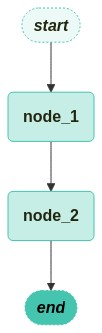

In [ ]:
# 서브그래프의 상태 타입 정의 (부모 그래프와 키를 공유하지 않음)
class ChildState(TypedDict):
    # 부모 그래프와 공유되지 않는 키들
    name: str


# 서브그래프의 첫 번째 노드: name 키에 초기값 설정
def subgraph_node_1(state: ChildState):
    return {"name": "Teddy " + state["name"]}


# 서브그래프의 두 번째 노드: name 값 그대로 반환
def subgraph_node_2(state: ChildState):
    return {"name": f'My name is {state["name"]}'}


# 서브그래프 빌더 초기화 및 노드 연결 구성
subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


# 부모 그래프의 상태 타입 정의
class ParentState(TypedDict):
    family_name: str    # <-----------subgraph state와 다름 
    full_name: str


# 부모 그래프의 첫 번째 노드: family_name 값 그대로 반환
def node_1(state: ParentState):
    return {"family_name": state["family_name"]}


# 부모 그래프의 두 번째 노드: 서브그래프와 상태 변환 및 결과 처리
def node_2(state: ParentState):
    # 부모 상태를 서브그래프 상태로 변환
    response = subgraph.invoke({"name": state["family_name"]})  # <----이 부분이 parent state를 가져와서 child에 넣어줌줌
    # 서브그래프 응답을 부모 상태로 변환
    return {"full_name": response["name"]}  # <------------response가 subgraph이니 이거를 다시 parent state에 넣어줌줌


# 부모 그래프 빌더 초기화 및 노드 연결 구성
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)

# 컴파일된 서브그래프 대신 서브그래프를 호출하는 node_2 함수 사용
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()


visualize_graph(graph, xray=True)

In [8]:
# 그래프 스트리밍 처리를 통한 서브그래프 데이터 청크 단위 순차 출력
# subgraphs=True 옵션으로 하위 그래프 포함하여 스트림 데이터 처리
for chunk in graph.stream({"family_name": "Lee"}):
    print(chunk)

{'node_1': {'family_name': 'Lee'}}
{'node_2': {'full_name': 'My name is Teddy Lee'}}


# 13) `subgraph`의 입력과 출력을 변환하는 방법

`subgraph` **상태**가 `parent graph` 상태와 완전히 독립적일 수 있습니다. 

즉, 두 그래프 간에 중복되는 상태 키(state keys) 가 없을 수 있습니다. 

이러한 경우에는 `subgraph`를 호출하기 전에 입력을 변환하고, 반환하기 전에 출력을 변환해야 합니다. 

## `graph`와 `subgraph` 정의

다음과 같이 3개의 `graph`를 정의하겠습니다.

- `parent graph`
  
- `parent graph` 에 의해 호출될 `child subgraph`

- `child graph` 에 의해 호출될 `grandchild subgraph`

## `grandchild` 정의

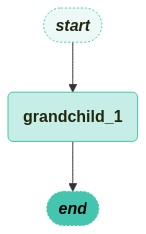

In [ ]:
# 상태 관리를 위한 TypedDict와 StateGraph 관련 모듈 임포트
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START, END


# 손자 노드의 상태를 정의하는 TypedDict 클래스, 문자열 타입의 my_grandchild_key 포함
class GrandChildState(TypedDict):
    my_grandchild_key: str  # <-------------다른 graph와 공유하지않음


# 손자 노드의 상태를 처리하는 함수, 입력된 문자열에 인사말 추가
def grandchild_1(state: GrandChildState) -> GrandChildState:
    # 자식 또는 부모 키는 여기서 접근 불가
    return {"my_grandchild_key": f'([GrandChild] {state["my_grandchild_key"]})'}


# 손자 노드의 상태 그래프 초기화
grandchild = StateGraph(GrandChildState)

# 상태 그래프에 손자 노드 추가
grandchild.add_node("grandchild_1", grandchild_1)

# 시작 노드에서 손자 노드로의 엣지 연결
grandchild.add_edge(START, "grandchild_1")

# 손자 노드에서 종료 노드로의 엣지 연결
grandchild.add_edge("grandchild_1", END)

# 정의된 상태 그래프 컴파일 및 실행 가능한 그래프 생성
grandchild_graph = grandchild.compile()

visualize_graph(grandchild_graph, xray=True)

In [11]:
# 그래프 호출
for chunk in grandchild_graph.stream(
    {"my_grandchild_key": "Hi, Teddy!"}):
    print(chunk)

{'grandchild_1': {'my_grandchild_key': '([GrandChild] Hi, Teddy!)'}}


## `child` 정의

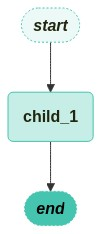

In [13]:
# 자식 상태 타입 정의를 위한 TypedDict 클래스
class ChildState(TypedDict):
    my_child_key: str


# 손자 그래프 호출 및 상태 변환 함수, 자식 상태를 입력받아 변환된 자식 상태 반환
def call_grandchild_graph(state: ChildState) -> ChildState:
    # 참고: 부모 또는 손자 키는 여기서 접근 불가능
    # 자식 상태 채널에서 손자 상태 채널로 상태 변환
    grandchild_graph_input = {"my_grandchild_key": state["my_child_key"]}
    # 손자 상태 채널에서 자식 상태 채널로 상태 변환 후 결과 반환
    grandchild_graph_output = grandchild_graph.invoke(grandchild_graph_input)
    return {"my_child_key": f'([Child] {grandchild_graph_output["my_grandchild_key"]})'}


# 자식 상태 그래프 초기화
child = StateGraph(ChildState)
# 참고: 컴파일된 그래프 대신 함수 전달
# 자식 그래프에 노드 추가 및 시작-종료 엣지 연결
child.add_node("child_1", call_grandchild_graph)
child.add_edge(START, "child_1")
child.add_edge("child_1", END)
# 자식 그래프 컴파일
child_graph = child.compile()

visualize_graph(child_graph, xray=True)

In [14]:
# child_graph 그래프 호출
for chunk in child_graph.stream({"my_child_key": "Hi, Teddy!"}):
    print(chunk)

{'child_1': {'my_child_key': '([Child] ([GrandChild] Hi, Teddy!))'}}


`grandchild_graph`의 호출을 별도의 함수(`call_grandchild_graph`)로 감싸고 있습니다. 

이 함수는 grandchild 그래프를 호출하기 전에 입력 상태를 변환하고, grandchild 그래프의 출력을 다시 child 그래프 상태로 변환합니다. 

만약 이러한 변환 없이 `grandchild_graph`를 직접 `.add_node`에 전달하면, child와 grandchild 상태 간에 공유된 상태 키(State Key) 이 없기 때문에 LangGraph에서 오류가 발생하게 됩니다.

**중요**

`child subgraph` 와 `grandchild subgraph`는 `parent graph`와 공유되지 않는 자신만의 **독립적인** `state`를 가지고 있다는 점에 유의하시기 바랍니다.

## `parent` 정의

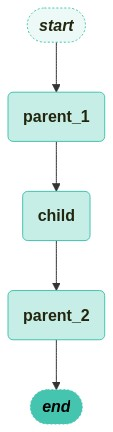

In [15]:
# 부모 상태 타입 정의를 위한 TypedDict 클래스
class ParentState(TypedDict):
    my_parent_key: str


# 부모 상태의 my_parent_key 값에 '[Parent1]' 문자열을 추가하는 변환 함수
def parent_1(state: ParentState) -> ParentState:
    # 참고: 자식 또는 손자 키는 여기서 접근 불가
    return {"my_parent_key": f'([Parent1] {state["my_parent_key"]})'}


# 부모 상태의 my_parent_key 값에 '[Parent2]' 문자열을 추가하는 변환 함수
def parent_2(state: ParentState) -> ParentState:
    return {"my_parent_key": f'([Parent2] {state["my_parent_key"]})'}


# 부모 상태와 자식 상태 간의 데이터 변환 및 자식 그래프 호출 처리
def call_child_graph(state: ParentState) -> ParentState:
    # 부모 상태 채널(my_parent_key)에서 자식 상태 채널(my_child_key)로 상태 변환
    child_graph_input = {"my_child_key": state["my_parent_key"]}
    # 자식 상태 채널(my_child_key)에서 부모 상태 채널(my_parent_key)로 상태 변환
    child_graph_output = child_graph.invoke(child_graph_input)
    return {"my_parent_key": child_graph_output["my_child_key"]}


# 부모 상태 그래프 초기화 및 노드 구성
parent = StateGraph(ParentState)
parent.add_node("parent_1", parent_1)

# 참고: 컴파일된 그래프가 아닌 함수를 전달
parent.add_node("child", call_child_graph)
parent.add_node("parent_2", parent_2)

# 상태 그래프의 실행 흐름을 정의하는 엣지 구성
parent.add_edge(START, "parent_1")
parent.add_edge("parent_1", "child")
parent.add_edge("child", "parent_2")
parent.add_edge("parent_2", END)

# 구성된 부모 상태 그래프의 컴파일 및 실행 가능한 그래프 생성
parent_graph = parent.compile()

visualize_graph(parent_graph, xray=True)

`child_graph` 호출을 별도의 함수 `call_child_graph` 로 감싸고 있는데, 이 함수는 자식 그래프를 호출하기 전에 입력 상태를 변환하고 자식 그래프의 출력을 다시 부모 그래프 상태로 변환합니다. 

변환 없이 `child_graph`를 직접 `.add_node`에 전달하면 부모와 자식 상태 간에 공유된 상태 키(State Key) 이 없기 때문에 LangGraph에서 오류가 발생합니다.

그럼, 부모 그래프를 실행하여 자식 및 손자 하위 그래프가 올바르게 호출되는지 확인해보겠습니다.

In [16]:
# 그래프 실행 및 "my_parent_key" 매개변수를 통한 "Hi, Teddy!" 값 전달
for chunk in parent_graph.stream({"my_parent_key": "Hi, Teddy!"}):
    print(chunk)

{'parent_1': {'my_parent_key': '([Parent1] Hi, Teddy!)'}}
{'child': {'my_parent_key': '([Child] ([GrandChild] ([Parent1] Hi, Teddy!)))'}}
{'parent_2': {'my_parent_key': '([Parent2] ([Child] ([GrandChild] ([Parent1] Hi, Teddy!))))'}}


# 14) 스트리밍 모드

`graph`의 전체 상태를 **스트리밍**하는 방법

LangGraph는 여러 스트리밍(Streaming) 모드를 지원합니다. 

주요 모드는 다음과 같습니다

- `values`: 이 스트리밍 모드는 그래프의 값들을 스트리밍합니다. 이는 각 노드가 호출된 후의 **그래프의 전체 상태**를 의미합니다.
- `updates`: 이 스트리밍 모드는 그래프의 업데이트 내용을 스트리밍합니다. 이는 각 노드가 호출된 후의 **그래프 상태에 대한 업데이트**를 의미합니다.
- `messages`: 이 스트리밍 모드는 각 노드의 메시지를 스트리밍합니다. 이때 **LLM 의 토큰 단위의 출력 스트리밍** 도 가능합니다.

## 그래프 정의하기

이 가이드에서는 간단한 에이전트를 사용하겠습니다.

c:\Users\user\anaconda3\envs\myenv\Lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


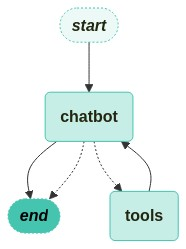

In [17]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_teddynote.tools import GoogleNews
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )


# 도구 리스트 생성
tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[search_keyword])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = graph_builder.compile()

visualize_graph(graph)

## 노드의 단계별 출력

**스트리밍 모드**
- `values`: 각 단계의 현재 상태 값 출력
- `updates`: 각 단계의 상태 업데이트만 출력 (기본값)
- `messages`: 각 단계의 메시지 출력

여기서 스트리밍의 의미는 LLM 출력시 토큰 단위로 스트리밍하는 개념이 아니라, 단계별로 출력하는 의미를 가집니다.

### `stream_mode = "values"`

`values` 모드는 각 단계의 현재 상태 값을 출력합니다.

**참고**

`chunk.items()`

- `key`: State 의 key 값
- `value`: State 의 key 에 대한하는 value

#### 동기(Synchronous) 방식의 스트리밍

- `chunk` 는 dictionary 형태(key: State 의 key, value: State 의 value)

In [18]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="values")
for chunk in graph.stream(inputs, stream_mode="values"):

    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

================================ Human Message =================================

AI 관련된 최신 뉴스를 검색해줘
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_y6ulddp9dsHFVq7GtVaVggWO)
 Call ID: call_y6ulddp9dsHFVq7GtVaVggWO
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

- "목표는 AI 3대 강국, 현실은 10위권 밖"…어디부터 손봐야 할까 - ZD넷 코리아
- '과기정통AI부' 설립, 부총리급 부처 격상 추진된다 - 전자신문
- ‘아시아 AI 허브’로 변모하는 일본 - 조선일보
- 부산 ‘AI 레이스’에 뛰어들었다…“글로벌 AI 허브도시 될 것” - 조선일보
- 부산시, 1조2000억 들여 AI 허브도시 만든다 - 국제신문
================================== Ai Message ==================================

다음은 AI 관련 최신 뉴스입니다:

1. **목표는 AI 3대 강국, 현실은 10위권 밖** - ZD넷 코리아
2. **'과기정통AI부' 설립, 부총리급 부처 격상 추진된다** - 전자신문
3. **‘아시아 AI 허브’로 변모하는 일본** - 조선일보
4. **부산 ‘AI 레이스’에 뛰어들었다…“글로벌 AI 허브도시 될 것”** - 조선일보
5. **부산시, 1조2000억 들여 AI 허브도시 만든다** - 국제신문

이 기사들은 AI의 발전과 관련된 다양한 주제를 다루고 있습니다.


#### 비동기(Asynchronous) 방식의 스트리밍

**참고**

- `astream()` 메서드는 비동기 스트림 처리를 통해 그래프를 실행하고 값 모드로 청크 단위 응답을 생성합니다.
- `async for` 문을 사용하여 비동기 스트림 처리를 수행합니다.

In [19]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="values")
async for chunk in graph.astream(inputs, stream_mode="values"):
    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

================================ Human Message =================================

AI 관련된 최신 뉴스를 검색해줘
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_efL5qtN6Q955ezjTXA95C5i2)
 Call ID: call_efL5qtN6Q955ezjTXA95C5i2
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

- "목표는 AI 3대 강국, 현실은 10위권 밖"…어디부터 손봐야 할까 - ZD넷 코리아
- '과기정통AI부' 설립, 부총리급 부처 격상 추진된다 - 전자신문
- ‘아시아 AI 허브’로 변모하는 일본 - 조선일보
- 부산 ‘AI 레이스’에 뛰어들었다…“글로벌 AI 허브도시 될 것” - 조선일보
- 부산시, 1조2000억 들여 AI 허브도시 만든다 - 국제신문
================================== Ai Message ==================================

최신 AI 관련 뉴스는 다음과 같습니다:

1. **"목표는 AI 3대 강국, 현실은 10위권 밖"…어디부터 손봐야 할까** - ZD넷 코리아
2. **'과기정통AI부' 설립, 부총리급 부처 격상 추진된다** - 전자신문
3. **‘아시아 AI 허브’로 변모하는 일본** - 조선일보
4. **부산 ‘AI 레이스’에 뛰어들었다…“글로벌 AI 허브도시 될 것”** - 조선일보
5. **부산시, 1조2000억 들여 AI 허브도시 만든다** - 국제신문

더 궁금한 내용이 있으면 말씀해 주세요!


최종 결과만 확인하고 싶은 경우, 다음과 같이 처리 합니다.

In [20]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

final_result = None

# 비동기 스트림 처리(stream_mode="values")
async for chunk in graph.astream(inputs, stream_mode="values"):
    final_result = chunk

# 최종 결과 출력
print(final_result["messages"][-1].content)

다음은 AI 관련 최신 뉴스입니다:

1. **"목표는 AI 3대 강국, 현실은 10위권 밖"…어디부터 손봐야 할까** - ZD넷 코리아
2. **'과기정통AI부' 설립, 부총리급 부처 격상 추진된다** - 전자신문
3. **‘아시아 AI 허브’로 변모하는 일본** - 조선일보
4. **부산 ‘AI 레이스’에 뛰어들었다…“글로벌 AI 허브도시 될 것”** - 조선일보
5. **부산시, 1조2000억 들여 AI 허브도시 만든다** - 국제신문

이 뉴스들은 현재 AI 분야에서 일어나고 있는 주요 동향과 계획들을 다루고 있습니다.


### `stream_mode = "updates"`

`updates` 모드는 각 단계에 대한 업데이트된 State 만 내보냅니다. 

- 출력은 노드 이름을 key 로, 업데이트된 값을 values 으로 하는 `dictionary` 입니다.

**참고**

`chunk.items()`

- `key`: 노드(Node) 의 이름
- `value`: 해당 노드(Node) 단계에서의 출력 값(dictionary). 즉, 여러 개의 key-value 쌍을 가진 dictionary 입니다.

#### 동기(Synchronous) 방식의 스트리밍

In [21]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="updates")
for chunk in graph.stream(inputs, stream_mode="updates"):
    # chunk 는 dictionary 형태(key: 노드, value: 노드의 상태 값)
    for node, value in chunk.items():
        if node:
            print(f"\n[Node: {node}]\n")
        if "messages" in value:
            value["messages"][-1].pretty_print()


[Node: chatbot]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_d4aGIp6xgiYWVycxvpsJbujR)
 Call ID: call_d4aGIp6xgiYWVycxvpsJbujR
  Args:
    query: AI

[Node: tools]

================================= Tool Message =================================
Name: search_keyword

- "목표는 AI 3대 강국, 현실은 10위권 밖"…어디부터 손봐야 할까 - ZD넷 코리아
- '과기정통AI부' 설립, 부총리급 부처 격상 추진된다 - 전자신문
- ‘아시아 AI 허브’로 변모하는 일본 - 조선일보
- 부산 ‘AI 레이스’에 뛰어들었다…“글로벌 AI 허브도시 될 것” - 조선일보
- 부산시, 1조2000억 들여 AI 허브도시 만든다 - 국제신문

[Node: chatbot]

================================== Ai Message ==================================

다음은 AI 관련 최신 뉴스입니다:

1. **"목표는 AI 3대 강국, 현실은 10위권 밖"…어디부터 손봐야 할까** - ZD넷 코리아
2. **'과기정통AI부' 설립, 부총리급 부처 격상 추진된다** - 전자신문
3. **‘아시아 AI 허브’로 변모하는 일본** - 조선일보
4. **부산 ‘AI 레이스’에 뛰어들었다…“글로벌 AI 허브도시 될 것”** - 조선일보
5. **부산시, 1조2000억 들여 AI 허브도시 만든다** - 국제신문

각 기사는 AI의 발전, 정책, 그리고 도시 개발에 대한 내용을 다루고 있습니다.


#### 비동기(Asynchronous) 방식의 스트리밍

In [22]:
# 질문 입력
inputs = {"messages": [("human", "LLM 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="updates")
async for chunk in graph.astream(inputs, stream_mode="updates"):
    # chunk 는 dictionary 형태(key: 노드, value: 노드의 상태 값)
    for node, value in chunk.items():
        if node:
            print(f"\n[Node: {node}]\n")
        if "messages" in value:
            value["messages"][-1].pretty_print()


[Node: chatbot]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_U2ENp7Vgl8zoMtLrxEKoQy2w)
 Call ID: call_U2ENp7Vgl8zoMtLrxEKoQy2w
  Args:
    query: LLM

[Node: tools]

================================= Tool Message =================================
Name: search_keyword

- 수세, AI 플랫폼 확장··· 워크로드 및 LLM 사용 제어 도구 추가 - CIO.com
- 코히어, GPU 2개로 구동하는 기업용 LLM 출시..."최대 성능·최소 컴퓨팅" - AI타임스
- 엔비디아, 자율주행차 위한 LLM과 비전언어모델 최적화 개발 키트... AI 성능 극대화 - 인공지능신문
- 넥스톰, '2025 산업지능화 컨퍼런스'에서 LLM 기반 AI 공장장 'STORMY' 공개 - 네이트 뉴스
- KETI, ‘AW 2025’서 LLM·모방학습 이용한 조립공정 자동화 기술 공개 - ZD넷 코리아

[Node: chatbot]

================================== Ai Message ==================================

최신 LLM(대형 언어 모델) 관련 뉴스는 다음과 같습니다:

1. **수세, AI 플랫폼 확장** - 워크로드 및 LLM 사용 제어 도구 추가 (CIO.com)
2. **코히어** - GPU 2개로 구동하는 기업용 LLM 출시, "최대 성능·최소 컴퓨팅" (AI타임스)
3. **엔비디아** - 자율주행차 위한 LLM과 비전언어모델 최적화 개발 키트 발표, AI 성능 극대화 (인공지능신문)
4. **넥스톰** - '2025 산업지능화 컨퍼런스'에서 LLM 기반 AI 공장장 'ST

### `stream_mode = "messages"`

`messages` 모드는 각 단계에 대한 메시지를 스트리밍합니다.

**참고**

- `chunk` 는 두 개의 요소를 가진 tuple 입니다.
  - `chunk_msg`: 실시간 출력 메시지
  - `metadata`: 노드 정보

  #### 동기(Synchronous) 방식의 스트리밍

In [23]:
# 질문 입력
inputs = {"messages": [("human", "LLM 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="messages")
# chunk_msg: 실시간 출력 메시지, metadata: 노드 정보
for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):

    # chatbot 노드에서 출력된 메시지만 출력
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)

    else:
        print(chunk_msg.content)
        print(f"\n\nmetadata: \n{metadata}\n\n")

#### 비동기(Asynchronous) 방식의 스트리밍

In [24]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="messages")
# chunk_msg: 실시간 출력 메시지, metadata: 노드 정보
async for chunk_msg, metadata in graph.astream(inputs, stream_mode="messages"):
    # chatbot 노드에서 출력된 메시지만 출력
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)
    else:
        print(chunk_msg.content)

## 특정 노드에 대한 출력 스트리밍

**참고**

- `metadata["langgraph_node"]` 를 통해 특정 노드에서 출력된 메시지만 출력할 수 있습니다.

특정 노드(Node) 에 대해서 출력하고 싶은 경우, stream_mode="messages" 를 통해 설정할 수 있습니다.

`stream_mode="messages"` 설정시, (`chunk_msg`, `metadata`) 형태로 메시지를 받습니다.
- `chunk_msg` 는 실시간 출력 메시지, 
- `metadata` 는 노드 정보를 의미합니다.

`metadata["langgraph_node"]` 를 통해 특정 노드에서 출력된 메시지만 출력할 수 있습니다.

(예시) chatbot 노드에서 출력된 메시지만 출력하는 경우

`metadata["langgraph_node"] == "chatbot"`

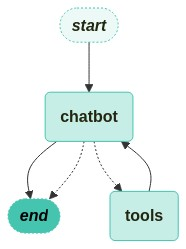

In [30]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_teddynote.tools import GoogleNews
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )


# 도구 리스트 생성
tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합 (tags 추가)
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[search_keyword])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = graph_builder.compile()

visualize_graph(graph, xray=True)

In [31]:
from langchain_core.messages import HumanMessage

# 사용자의 메시지를 딕셔너리 형태로 입력 데이터 구성
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# stream_mode="messages" 를 통한 스트리밍 처리
for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # HumanMessage 가 아닌 최종 노드의 유효한 컨텐츠만 출력 처리
    if (
        chunk_msg.content
        and not isinstance(chunk_msg, HumanMessage)
        and metadata["langgraph_node"] == "chatbot"
    ):
        print(chunk_msg.content, end="", flush=True)
        print(metadata)

## 사용자 정의 `tag` 필터링 된 스트리밍

LLM 의 출력이 여러 군데에서 발생하는 경우, 특정 노드에서 출력된 메시지만 출력하고 싶은 경우가 있습니다.

이러한 경우, `tags` 를 추가하여 출력하고 싶은 노드만 선별할 수 있습니다.

llm 에 tags 를 추가하는 방법은 다음과 같습니다. `tags` 는 리스트 형태로 추가할 수 있습니다.

`llm.with_config(tags=["WANT_TO_STREAM"])`


이를 통해 이벤트를 더 정확하게 필터링하여 해당 모델에서 발생한 이벤트만 유지할 수 있습니다.

아래 예시는 `WANT_TO_STREAM` 태그가 있는 경우만 출력하는 예시입니다.

In [32]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 이벤트 스트림 처리(astream_events)
async for event in graph.astream_events(inputs, version="v2"):
    # 이벤트 종류와 태그 정보 추출
    kind = event["event"]
    tags = event.get("tags", [])

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    if kind == "on_chat_model_stream" and "WANT_TO_STREAM" in tags:
        # 이벤트 데이터 추출
        data = event["data"]

        # 출력 메시지
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

C:\Users\user\AppData\Local\Temp\ipykernel_12604\731170980.py:5: LangChainBetaWarning: This API is in beta and may change in the future.
  async for event in graph.astream_events(inputs, version="v2"):


다음은 AI 관련 최신 뉴스입니다:

1. **목표는 AI 3대 강국, 현실은 10위권 밖** - ZD넷 코리아
2. **'과기정통AI부' 설립, 부총리급 부처 격상 추진된다** - 전자신문
3. **‘아시아 AI 허브’로 변모하는 일본** - 조선일보
4. **부산 ‘AI 레이스’에 뛰어들었다…“글로벌 AI 허브도시 될 것”** - 조선일보
5. **부산시, 1조2000억 들여 AI 허브도시 만든다** - 국제신문

더 자세한 내용을 원하시면 특정 기사에 대해 알려주세요!

## 도구 호출에 대한 스트리밍 출력

- `AIMessageChunk`: 실시간 토큰 단위의 출력 메시지
- `tool_call_chunks`: 도구 호출 청크. 만약 `tool_call_chunks` 가 존재하는 경우, 도구 호출 청크를 누적하여 출력합니다. (도구 토큰은 이 속성을 보고 판단하여 출력)

In [33]:
from langchain_core.messages import AIMessageChunk, HumanMessage

# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 첫 번째 메시지 처리 여부 플래그 설정
first = True

# 비동기 스트림 처리를 통한 메시지 및 메타데이터 순차 처리
for msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # 사용자 메시지가 아닌 경우의 컨텐츠 출력 처리
    if msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="", flush=True)

    # AI 메시지 청크 처리 및 누적
    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg

        # 도구 호출 청크 존재 시 누적된 도구 호출 정보 출력
        if msg.tool_call_chunks:
            print(gathered.tool_calls[0]["args"])

## Subgraphs 스트리밍 출력

이번에는 Subgraphs 를 통해 스트리밍 출력을 확인하는 방법을 알아보겠습니다.

Subgraphs 는 그래프의 일부를 서브그래프로 정의하는 기능입니다.

**흐름**

- Subgraphs 에서는 기존의 최신 뉴스를 검색하는 기능을 재사용합니다.
- Parent Graph 에서는 검색된 최신 뉴스를 바탕으로 SNS 포스트를 생성하는 기능을 추가합니다.

In [35]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_teddynote.tools import GoogleNews
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )


# 도구 리스트 생성
tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합 (tags 추가)
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# SNS 포스트 생성 함수 정의
def create_sns_post(state: State):
    # SNS 포스트 생성을 위한 프롬프트
    sns_prompt = """
    이전 대화 내용을 바탕으로 SNS 게시글 형식으로 변환해주세요.
    다음 형식을 따라주세요:
    - 해시태그 포함
    - 이모지 사용
    - 간결하고 흥미로운 문체 사용
    - 200자 이내로 작성
    """
    messages = state["messages"] + [("human", sns_prompt)]
    sns_llm = ChatOpenAI(model="gpt-4o-mini").with_config(tags=["WANT_TO_STREAM2"])
    return {"messages": [sns_llm.invoke(messages)]}


# 서브그래프 생성
def create_subgraph():
    # 서브그래프용 상태 그래프 생성
    subgraph = StateGraph(State)

    # 챗봇 노드 추가
    subgraph.add_node("chatbot", chatbot)

    # 도구 노드 생성 및 추가
    tool_node = ToolNode(tools=[search_keyword])
    subgraph.add_node("tools", tool_node)

    # 조건부 엣지 추가
    subgraph.add_conditional_edges(
        "chatbot",
        tools_condition,
    )

    # tools > chatbot
    subgraph.add_edge("tools", "chatbot")

    # START > chatbot
    subgraph.add_edge(START, "chatbot")

    # chatbot > END
    subgraph.add_edge("chatbot", END)

    return subgraph.compile()


# 메인 그래프 생성
graph_builder = StateGraph(State)

# 서브그래프 추가
subgraph = create_subgraph()
graph_builder.add_node("news_subgraph", subgraph)

# SNS 포스트 생성 노드 추가
graph_builder.add_node("sns_post", create_sns_post)

# START > news_subgraph
graph_builder.add_edge(START, "news_subgraph")

# news_subgraph > sns_post
graph_builder.add_edge("news_subgraph", "sns_post")

# sns_post > END
graph_builder.add_edge("sns_post", END)

# 그래프 컴파일
graph = graph_builder.compile()
# 그래프 시각화
visualize_graph(graph, xray=True)

[ERROR] Visualize Graph Error: Node.__new__() missing 2 required positional arguments: 'data' and 'metadata'


### Subgraphs 출력을 '생략' 하는 경우

In [36]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 노드 업데이트 정보 순차적 처리 및 출력
for chunk in graph.stream(inputs, stream_mode="updates"):
    # node_name: 현재 처리 중인 노드명, node_chunk: 해당 노드의 청크 데이터
    for node_name, node_chunk in chunk.items():
        # 현재 처리 중인 노드 구분선 출력
        print(f"\n========= Update from node {node_name} =========\n")
        # 해당 노드의 업데이트된 데이터 출력
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)


========= Update from node news_subgraph =========

================================== Ai Message ==================================

다음은 AI 관련 최신 뉴스입니다:

1. **"목표는 AI 3대 강국, 현실은 10위권 밖"…어디부터 손봐야 할까** - ZD넷 코리아
2. **'과기정통AI부' 설립, 부총리급 부처 격상 추진된다** - 전자신문
3. **‘아시아 AI 허브’로 변모하는 일본** - 조선일보
4. **부산 ‘AI 레이스’에 뛰어들었다…“글로벌 AI 허브도시 될 것”** - 조선일보
5. **부산시, 1조2000억 들여 AI 허브도시 만든다** - 국제신문

더 궁금한 내용이 있으시면 말씀해 주세요!

========= Update from node sns_post =========

================================== Ai Message ==================================

🚀 AI의 미래, 대한민국과 일본이 뜨겁다! 🇰🇷🇯🇵 부산은 AI 허브도시로 변신 중! 💡 과기정통AI부도 부총리급으로 격상 추진! 🌟 아시아 AI 허브로의 도약이 기대된다! #AI #부산 #아시아AI허브 #기술혁신 #미래기술


### Subgraphs 출력도 '포함' 하는 경우

**참고**

- `subgraphs=True` 를 통해 Subgraphs 의 출력도 포함할 수 있습니다.
- `(namespace, chunk)` 형태로 출력됩니다.

In [37]:
# 사용자의 메시지를 딕셔너리 형태로 입력 데이터 구성
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}


# 네임스페이스 문자열을 보기 좋은 형식으로 변환하는 포맷팅 함수
def format_namespace(namespace):
    return namespace[-1].split(":")[0] if len(namespace) > 0 else "parent graph"


# subgraphs=True 를 통해 서브그래프의 출력도 포함(namespace, chunk) 형태로 출력됩니다.
for namespace, chunk in graph.stream(inputs, stream_mode="updates", subgraphs=True):
    # node_name: 현재 처리 중인 노드명, node_chunk: 해당 노드의 청크 데이터
    for node_name, node_chunk in chunk.items():
        print(
            f"\n========= Update from node [{node_name}] in [{format_namespace(namespace)}] =========\n"
        )

        # 노드의 청크 데이터 출력
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)

TypeError: Pregel.stream() got an unexpected keyword argument 'subgraphs'

#### Subgraphs 안에서 LLM 출력 토큰 단위 스트리밍

**참고**

- `kind` 는 이벤트 종류를 나타냅니다.
- 이벤트 종류는 [StreamEvent 타입별 정리](https://wikidocs.net/265576) 에서 확인하세요!

In [38]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"


kind = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= on_chat_model_start =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        # 이벤트 데이터 추출
        data = event["data"]

        # 토큰 단위의 스트리밍 출력
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)

TypeError: Pregel.astream() got an unexpected keyword argument 'subgraphs'

#### 특정 tags 만 스트리밍 출력하는 경우

- `ONLY_STREAM_TAGS` 를 통해 스트리밍 출력하고 싶은 tags 만 설정할 수 있습니다.
- 여기서는 "WANT_TO_STREAM" 는 출력에서 배제하고 "WANT_TO_STREAM2" 만 출력하는 경우를 확인합니다.

In [39]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"


# 스트리밍 출력하고 싶은 tags 만 설정 (여기서는 "WANT_TO_STREAM" 는 출력에서 배제)
ONLY_STREAM_TAGS = ["WANT_TO_STREAM"]

kind = None
tags = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]
    tags = event.get("tags", [])

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= tags: {tags} =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        for tag in tags:
            if tag in ONLY_STREAM_TAGS:
                # 이벤트 데이터 추출
                data = event["data"]

                # 출력 메시지
                if data["chunk"].content:
                    print(data["chunk"].content, end="", flush=True)
    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)

TypeError: Pregel.astream() got an unexpected keyword argument 'subgraphs'